<a href="https://colab.research.google.com/github/BobSheehan23/LighthouseMacro/blob/main/Copy_of_Securities_Lending_Alpha_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import statsmodels.api as sm

# Set plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

# --- Load Your Data ---
# For this template, we'll create a sample dataframe.
# In your actual analysis, you would load your data here, for example:
# df = pd.read_csv('path/to/your/equilend_data.csv')

# Creating a mock dataframe that resembles securities lending data
data = {
    'date': pd.to_datetime(np.repeat(pd.date_range('2023-01-01', periods=100), 50)),
    'ticker': np.tile([f'STOCK_{i}' for i in range(50)], 100),
    'shares_on_loan': np.random.randint(1e5, 1e7, 5000),
    'lendable_inventory': np.random.randint(5e6, 5e7, 5000),
    'shares_outstanding': np.random.randint(1e8, 1e9, 5000),
    'avg_daily_volume_30d': np.random.randint(5e5, 5e6, 5000),
    'borrow_fee_bps': np.random.uniform(10, 500, 5000),
    'forward_1m_return': np.random.uniform(-0.1, 0.1, 5000),
    'market_cap': np.random.uniform(1e9, 1e11, 5000) # For size factor
}
df = pd.DataFrame(data)

# Ensure lendable inventory is always greater than shares on loan
df['lendable_inventory'] = df['shares_on_loan'] + np.random.randint(1e5, 1e7, 5000)

print("Dataset loaded successfully. Here's a preview:")
df.head()

Dataset loaded successfully. Here's a preview:


,date,ticker,shares_on_loan,lendable_inventory,shares_outstanding,avg_daily_volume_30d,borrow_fee_bps,forward_1m_return,market_cap
0,2023-01-01,STOCK_0,8021479,11468694,374066779,3088097,27.205242,0.050862,2.991370e+10
1,2023-01-01,STOCK_1,4482402,13332486,456574102,1683651,376.011582,0.097689,3.638392e+10
2,2023-01-01,STOCK_2,7984490,8646648,207602238,4855751,51.438735,0.079983,6.085643e+09
3,2023-01-01,STOCK_3,9053483,15293841,811134492,1309653,79.071497,0.009768,8.593943e+10
4,2023-01-01,STOCK_4,8788336,16539684,767679124,4732341,104.299645,-0.015315,2.346009e+10


In [ ]:
# --- Part II: Factor Engineering ---

# 1. Utilization: Shares on Loan / Lendable Inventory
df['utilization'] = df['shares_on_loan'] / df['lendable_inventory']

# 2. Loaned as Percentage of Shares Outstanding
df['loaned_pct_outstanding'] = df['shares_on_loan'] / df['shares_outstanding']

# 3. Borrow Fee Quartile (as a proxy for specialness/demand)
# Calculate quartiles daily to reflect changing market conditions
df['borrow_fee_quartile'] = df.groupby('date')['borrow_fee_bps'].transform(
    lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')
)

# 4. Size Factor (using Market Cap)
# Calculate quartiles daily
df['market_cap_quartile'] = df.groupby('date')['market_cap'].transform(
    lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')
)

# 5. Liquidity Factor (using Avg Daily Volume)
# Calculate quartiles daily
df['volume_quartile'] = df.groupby('date')['avg_daily_volume_30d'].transform(
    lambda x: pd.qcut(x, 4, labels=False, duplicates='drop')
)


print("\nEngineered factors added. Here's a preview with new columns:")
display(df.head())


Engineered factors added. Here's a preview with new columns:


,date,ticker,shares_on_loan,lendable_inventory,shares_outstanding,avg_daily_volume_30d,borrow_fee_bps,forward_1m_return,market_cap,utilization,loaned_pct_outstanding,borrow_fee_quartile,market_cap_quartile,volume_quartile
0,2023-01-01,STOCK_0,8021479,11468694,374066779,3088097,27.205242,0.050862,2.991370e+10,0.699424,0.021444,0,1,2
1,2023-01-01,STOCK_1,4482402,13332486,456574102,1683651,376.011582,0.097689,3.638392e+10,0.336202,0.009817,3,1,0
2,2023-01-01,STOCK_2,7984490,8646648,207602238,4855751,51.438735,0.079983,6.085643e+09,0.923420,0.038461,0,0,3
3,2023-01-01,STOCK_3,9053483,15293841,811134492,1309653,79.071497,0.009768,8.593943e+10,0.591969,0.011162,0,3,0
4,2023-01-01,STOCK_4,8788336,16539684,767679124,4732341,104.299645,-0.015315,2.346009e+10,0.531348,0.011448,0,0,3


In [ ]:
# --- Part III: Backtesting Framework ---

# Calculate factor returns for quartile factors
# For each date and each quartile of each factor, calculate the average forward 1-month return
factor_returns = df.groupby(['date', 'borrow_fee_quartile'])['forward_1m_return'].mean().unstack()
factor_returns.columns = [f'borrow_fee_quartile_{c}_return' for c in factor_returns.columns]

market_cap_returns = df.groupby(['date', 'market_cap_quartile'])['forward_1m_return'].mean().unstack()
market_cap_returns.columns = [f'market_cap_quartile_{c}_return' for c in market_cap_returns.columns]

volume_returns = df.groupby(['date', 'volume_quartile'])['forward_1m_return'].mean().unstack()
volume_returns.columns = [f'volume_quartile_{c}_return' for c in volume_returns.columns]

# Combine factor returns
all_factor_returns = pd.concat([factor_returns, market_cap_returns, volume_returns], axis=1)

print("\nCalculated daily factor returns for quartile-based factors. Here's a preview:")
display(all_factor_returns.head())


Calculated daily factor returns for quartile-based factors. Here's a preview:


,borrow_fee_quartile_0_return,borrow_fee_quartile_1_return,borrow_fee_quartile_2_return,borrow_fee_quartile_3_return,market_cap_quartile_0_return,market_cap_quartile_1_return,market_cap_quartile_2_return,market_cap_quartile_3_return,volume_quartile_0_return,volume_quartile_1_return,volume_quartile_2_return,volume_quartile_3_return
date,,,,,,,,,,,,
2023-01-01,0.010922,0.002440,0.016592,-0.012014,0.009943,0.001191,-0.003446,0.008614,0.007825,0.010386,-0.004742,0.003441
2023-01-02,0.016984,0.004799,0.012852,0.013929,0.009926,-0.010235,0.021502,0.026879,0.026752,0.030109,-0.023192,0.014068
2023-01-03,0.032391,0.002664,0.003962,-0.022985,0.012630,-0.009161,-0.017233,0.027255,-0.021192,0.005995,0.007693,0.024079
2023-01-04,0.016711,-0.010591,0.002406,-0.010310,0.005117,-0.032168,-0.008930,0.031665,0.019071,0.028722,-0.016533,-0.031477
2023-01-05,0.006912,0.012469,0.009916,0.012845,0.027661,0.001866,0.002052,0.009143,0.006550,0.003359,-0.003781,0.034260



Calculated cumulative factor returns. Here's a preview:


,borrow_fee_quartile_0_return,borrow_fee_quartile_1_return,borrow_fee_quartile_2_return,borrow_fee_quartile_3_return,market_cap_quartile_0_return,market_cap_quartile_1_return,market_cap_quartile_2_return,market_cap_quartile_3_return,volume_quartile_0_return,volume_quartile_1_return,volume_quartile_2_return,volume_quartile_3_return
date,,,,,,,,,,,,
2023-01-01,0.010922,0.002440,0.016592,-0.012014,0.009943,0.001191,-0.003446,0.008614,0.007825,0.010386,-0.004742,0.003441
2023-01-02,0.028091,0.007250,0.029657,0.001747,0.019967,-0.009056,0.017982,0.035725,0.034786,0.040807,-0.027824,0.017558
2023-01-03,0.061392,0.009934,0.033736,-0.021279,0.032849,-0.018134,0.000440,0.063954,0.012857,0.047047,-0.020345,0.042059
2023-01-04,0.079129,-0.000763,0.036224,-0.031370,0.038134,-0.049719,-0.008494,0.097644,0.032173,0.077120,-0.036542,0.009259
2023-01-05,0.086588,0.011696,0.046499,-0.018927,0.066849,-0.047946,-0.006460,0.107680,0.038934,0.080739,-0.040185,0.043836


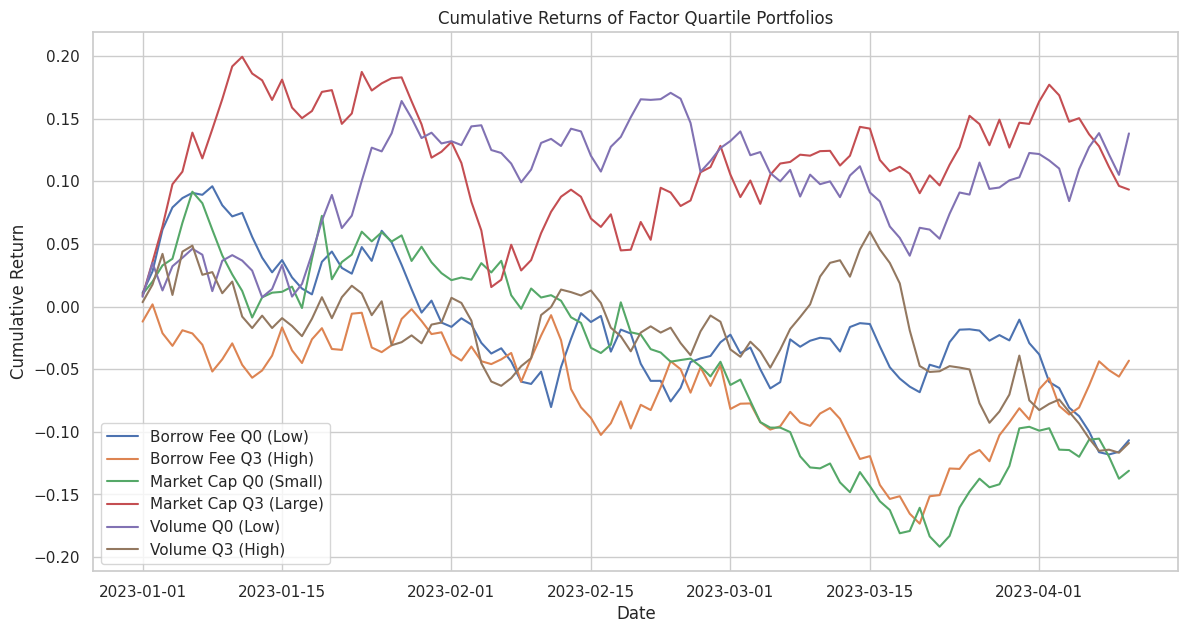

In [ ]:
# Calculate cumulative returns
cumulative_returns = (1 + all_factor_returns).cumprod() - 1

print("\nCalculated cumulative factor returns. Here's a preview:")
display(cumulative_returns.head())

# Plot cumulative returns
plt.figure(figsize=(14, 7))

# Plotting Borrow Fee Quartile Returns
plt.plot(cumulative_returns.index, cumulative_returns['borrow_fee_quartile_0_return'], label='Borrow Fee Q0 (Low)')
plt.plot(cumulative_returns.index, cumulative_returns['borrow_fee_quartile_3_return'], label='Borrow Fee Q3 (High)')

# Plotting Market Cap Quartile Returns
plt.plot(cumulative_returns.index, cumulative_returns['market_cap_quartile_0_return'], label='Market Cap Q0 (Small)')
plt.plot(cumulative_returns.index, cumulative_returns['market_cap_quartile_3_return'], label='Market Cap Q3 (Large)')

# Plotting Volume Quartile Returns
plt.plot(cumulative_returns.index, cumulative_returns['volume_quartile_0_return'], label='Volume Q0 (Low)')
plt.plot(cumulative_returns.index, cumulative_returns['volume_quartile_3_return'], label='Volume Q3 (High)')


plt.title('Cumulative Returns of Factor Quartile Portfolios')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()

## Part IV: Advanced Factor Refinement

In this section, we will delve deeper into the engineered factors and explore ways to refine them for better predictive power. This might include:

- **Handling Outliers and Skewness:** Investigating and potentially transforming factors to address extreme values or non-normal distributions.
- **Factor Neutralization:** Neutralizing factors against known market-wide factors (e.g., market beta, size, value) to isolate the unique alpha component.
- **Time-Series Analysis of Factor Returns:** Examining the time-series properties of factor returns, such as autocorrelation and stationarity.
- **Cross-Sectional Regression Analysis:** Using cross-sectional regressions to formally test the significance of factors and estimate their risk premia.
- **Exploring Alternative Factor Definitions:** Considering different ways to define or combine factors.

In [ ]:
import pandas as pd
import numpy as np

# --- Dummy Data Generation (replace with actual data loading) ---
# For demonstration purposes, let's create a dummy DataFrame
# In a real scenario, you would load your daily securities finance data here.
dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=10, freq='D'))
security_ids = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
data = []
for date in dates:
    for sec_id in security_ids:
        data.append({
            'Date': date,
            'SecurityID': sec_id,
            'IndicativeFee': np.random.uniform(0.01, 5.0), # Example values
            'DemandSupplyRatio': np.random.uniform(0.1, 10.0),
            'ActiveUtilization': np.random.uniform(0.05, 0.95),
            'DailyReturn': np.random.uniform(-0.02, 0.02) # Added for portfolio examples
        })
df_securities_data = pd.DataFrame(data)

def single_factor_ranking(df, date, factor_name):
    """
    Ranks securities for a given date based on a single factor.
    Higher factor value indicates higher underperformance likelihood.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()
    daily_df['Rank'] = daily_df[factor_name].rank(ascending=False, method='min')
    return daily_df.sort_values(by='Rank')

# Example Usage: Rank for a specific date using 'IndicativeFee'
date_to_rank = pd.to_datetime('2023-01-05')
ranked_securities = single_factor_ranking(df_securities_data, date_to_rank, 'IndicativeFee')
print(f"Single-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')} (Factor: Indicative Fee):\n", ranked_securities)

Single-Factor Ranking for 2023-01-05 (Factor: Indicative Fee):
          Date SecurityID  IndicativeFee  DemandSupplyRatio  ActiveUtilization  \
21 2023-01-05      GOOGL       2.740704           3.710874           0.109492   
23 2023-01-05       AMZN       2.235225           5.399919           0.330069   
24 2023-01-05       TSLA       0.655358           9.318218           0.425026   
20 2023-01-05       AAPL       0.477355           1.864242           0.674282   
22 2023-01-05       MSFT       0.046458           3.934986           0.282789   

    DailyReturn  Rank  
21     0.000397   1.0  
23     0.002312   2.0  
24     0.009935   3.0  
20     0.009430   4.0  
22     0.004259   5.0  


In [ ]:
# --- Continue with df_securities_data from above ---

def composite_factor_ranking(df, date, factors, weights=None):
    """
    Ranks securities for a given date based on a composite score of multiple factors.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    if weights is None:
        weights = [1.0] * len(factors) # Equal weights by default
    elif len(weights) != len(factors):
        raise ValueError("Number of weights must match number of factors.")

    # Calculate percentile ranks for each factor
    for factor in factors:
        # Assuming higher factor value means higher underperformance probability, so rank higher values as higher percentile
        daily_df[f'{factor}_Rank'] = daily_df[factor].rank(pct=True, ascending=True) * 100

    # Calculate composite score (sum of weighted ranks)
    daily_df['CompositeScore'] = 0
    for i, factor in enumerate(factors):
        daily_df['CompositeScore'] += daily_df[f'{factor}_Rank'] * weights[i]

    # Final ranking based on composite score (higher score = higher rank for underperformance)
    daily_df['CompositeRank'] = daily_df['CompositeScore'].rank(ascending=False, method='min')
    return daily_df.sort_values(by='CompositeRank')

# Example Usage: Rank for a specific date using a composite of factors
date_to_rank = pd.to_datetime('2023-01-05')
composite_factors = ['IndicativeFee', 'ActiveUtilization']
# Example with equal weights, you could also define custom weights like [0.6, 0.4]
ranked_securities_composite = composite_factor_ranking(df_securities_data, date_to_rank, composite_factors)
print(f"\nComposite-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')}:\n", ranked_securities_composite)


Composite-Factor Ranking for 2023-01-05:
          Date SecurityID  IndicativeFee  DemandSupplyRatio  ActiveUtilization  \
20 2023-01-05       AAPL       0.477355           1.864242           0.674282   
23 2023-01-05       AMZN       2.235225           5.399919           0.330069   
24 2023-01-05       TSLA       0.655358           9.318218           0.425026   
21 2023-01-05      GOOGL       2.740704           3.710874           0.109492   
22 2023-01-05       MSFT       0.046458           3.934986           0.282789   

    DailyReturn  IndicativeFee_Rank  ActiveUtilization_Rank  CompositeScore  \
20     0.009430                40.0                   100.0           140.0   
23     0.002312                80.0                    60.0           140.0   
24     0.009935                60.0                    80.0           140.0   
21     0.000397               100.0                    20.0           120.0   
22     0.004259                20.0                    40.0            60.0

In [ ]:
# --- Continue with df_securities_data. For this example, let's assume we have daily returns ---
# Add dummy returns for demonstration
# df_securities_data['DailyReturn'] = np.random.uniform(-0.02, 0.02, len(df_securities_data))

def long_short_portfolio(df, rebalance_freq='M', factor_name='IndicativeFee'):
    """
    Simulates a long-short portfolio based on a given factor.
    Assumes higher factor value means higher likelihood of underperformance (short side).
    """
    portfolio_returns = []
    df_sorted = df.sort_values(by=['Date', factor_name], ascending=[True, False])

    # Get unique rebalancing dates
    # For monthly rebalance, get the last day of each month
    if rebalance_freq == 'M':
        rebalance_dates = df_sorted['Date'].dt.to_period('M').unique().to_timestamp('M').sort_values()
    else:
        # Simple daily rebalance for demonstration if no specific freq
        rebalance_dates = df_sorted['Date'].unique()

    for i in range(len(rebalance_dates) - 1):
        start_date = rebalance_dates[i]
        end_date = rebalance_dates[i+1] if i + 1 < len(rebalance_dates) else df_sorted['Date'].max()

        # Get data for the current rebalancing period
        current_period_data = df_sorted[df_sorted['Date'] == start_date].copy()

        if current_period_data.empty:
            continue

        # Sort and get deciles
        current_period_data['Decile'] = pd.qcut(
            current_period_data[factor_name],
            q=10,
            labels=False,
            duplicates='drop'
        )

        # Long portfolio: securities in the lowest decile of the factor (best performers)
        # Short portfolio: securities in the highest decile of the factor (worst performers)
        long_securities = current_period_data[current_period_data['Decile'] == 0]['SecurityID'].tolist()
        short_securities = current_period_data[current_period_data['Decile'] == 9]['SecurityID'].tolist()

        if not long_securities or not short_securities:
            continue

        # Calculate daily returns for the holding period
        holding_period_data = df_sorted[
            (df_sorted['Date'] > start_date) & (df_sorted['Date'] <= end_date)
        ].copy()

        daily_portfolio_return = 0
        if not holding_period_data.empty:
            # Simple equal-weighted returns (conceptual)
            long_returns = holding_period_data[holding_period_data['SecurityID'].isin(long_securities)]['DailyReturn'].mean()
            short_returns = holding_period_data[holding_period_data['SecurityID'].isin(short_securities)]['DailyReturn'].mean()

            # Long-Short strategy: long returns - short returns
            daily_portfolio_return = long_returns - short_returns

        portfolio_returns.append({
            'Date': start_date,
            'PortfolioReturn': daily_portfolio_return
        })

    return pd.DataFrame(portfolio_returns)

# Example Usage: Simulate a monthly rebalanced portfolio based on 'IndicativeFee'
# portfolio_results = long_short_portfolio(df_securities_data, rebalance_freq='M', factor_name='IndicativeFee')
# print("\nLong-Short Portfolio Returns (Sample):\n", portfolio_results.head())
# To calculate annualized returns and Information Ratio, you'd extend this with full time series data and benchmark.

In [ ]:
# --- Dummy Data Generation (replace with actual data loading) ---
# Assuming you have daily data for Equity Utilization, Bond Utilization, and CDS Spreads
# In a real scenario, these would come from different sources and need to be joined.
cross_asset_data = []
for date in dates: # Using 'dates' from Model 1 example
    for sec_id in security_ids:
        cross_asset_data.append({
            'Date': date,
            'SecurityID': sec_id,
            'EquityUtilization': np.random.uniform(0.01, 0.99),
            'BondUtilization': np.random.uniform(0.01, 0.50), # Bonds typically lower utilization
            'CDSSpread': np.random.uniform(10, 500) # Basis points
        })
df_cross_asset = pd.DataFrame(cross_asset_data)
# Add dummy returns for analysis
# df_cross_asset['DailyReturn'] = np.random.uniform(-0.02, 0.02, len(df_cross_asset))

def cross_asset_sentiment_indicator(df, date):
    """
    Calculates a combined cross-asset sentiment rank for a given date.
    Assumes higher ranks indicate more negative sentiment.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    # Calculate percentile ranks for each signal
    # Higher Equity/Bond Utilization and higher CDS Spread indicate more negative sentiment
    daily_df['EquityUtilization_Rank'] = daily_df['EquityUtilization'].rank(pct=True, ascending=True) * 100
    daily_df['BondUtilization_Rank'] = daily_df['BondUtilization'].rank(pct=True, ascending=True) * 100
    daily_df['CDSSpread_Rank'] = daily_df['CDSSpread'].rank(pct=True, ascending=True) * 100

    # Create a combined percentile rank (e.g., equal weighted average)
    daily_df['CombinedSentimentRank'] = (
        daily_df['EquityUtilization_Rank'] +
        daily_df['BondUtilization_Rank'] +
        daily_df['CDSSpread_Rank']
    ) / 3

    # Final ranking based on combined sentiment
    daily_df['CrossAssetRank'] = daily_df['CombinedSentimentRank'].rank(ascending=True, method='min')
    return daily_df.sort_values(by='CrossAssetRank')

# Example Usage: Calculate cross-asset sentiment for a specific date
# date_to_analyze = pd.to_datetime('2023-01-05')
# cross_asset_ranks = cross_asset_sentiment_indicator(df_cross_asset, date_to_analyze)
# print(f"\nCross-Asset Sentiment Ranking for {date_to_analyze.strftime('%Y-%m-%d')}:\n", cross_asset_ranks)

# You would then integrate this into a long-short portfolio construction similar to Model Template 2,
# using 'CrossAssetRank' to define long and short baskets.

NameError: name 'dates' is not defined

In [ ]:
# --- Dummy Data Generation (replace with actual data loading) ---
# Assuming you have daily data for Equity Utilization, Bond Utilization, and CDS Spreads
# In a real scenario, these would come from different sources and need to be joined.
dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=10, freq='D'))
security_ids = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
cross_asset_data = []
for date in dates: # Using 'dates' from Model 1 example
    for sec_id in security_ids:
        cross_asset_data.append({
            'Date': date,
            'SecurityID': sec_id,
            'EquityUtilization': np.random.uniform(0.01, 0.99),
            'BondUtilization': np.random.uniform(0.01, 0.50), # Bonds typically lower utilization
            'CDSSpread': np.random.uniform(10, 500) # Basis points
        })
df_cross_asset = pd.DataFrame(cross_asset_data)
# Add dummy returns for analysis
df_cross_asset['DailyReturn'] = np.random.uniform(-0.02, 0.02, len(df_cross_asset))

def cross_asset_sentiment_indicator(df, date):
    """
    Calculates a combined cross-asset sentiment rank for a given date.
    Assumes higher ranks indicate more negative sentiment.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    # Calculate percentile ranks for each signal
    # Higher Equity/Bond Utilization and higher CDS Spread indicate more negative sentiment
    daily_df['EquityUtilization_Rank'] = daily_df['EquityUtilization'].rank(pct=True, ascending=True) * 100
    daily_df['BondUtilization_Rank'] = daily_df['BondUtilization'].rank(pct=True, ascending=True) * 100
    daily_df['CDSSpread_Rank'] = daily_df['CDSSpread'].rank(pct=True, ascending=True) * 100

    # Create a combined percentile rank (e.g., equal weighted average)
    daily_df['CombinedSentimentRank'] = (
        daily_df['EquityUtilization_Rank'] +
        daily_df['BondUtilization_Rank'] +
        daily_df['CDSSpread_Rank']
    ) / 3

    # Final ranking based on combined sentiment
    daily_df['CrossAssetRank'] = daily_df['CombinedSentimentRank'].rank(ascending=False, method='min')
    return daily_df.sort_values(by='CrossAssetRank')

# Example Usage: Calculate cross-asset sentiment for a specific date
date_to_analyze = pd.to_datetime('2023-01-05')
cross_asset_ranks = cross_asset_sentiment_indicator(df_cross_asset, date_to_analyze)
print(f"\nCross-Asset Sentiment Ranking for {date_to_analyze.strftime('%Y-%m-%d')}:\n", cross_asset_ranks)

# You would then integrate this into a long-short portfolio construction similar to Model Template 2,
# using 'CrossAssetRank' to define long and short baskets.
# A simplified example of applying the long-short logic:
portfolio_results_cross_asset = long_short_portfolio(df_cross_asset, rebalance_freq='D', factor_name='CombinedSentimentRank')
print("\nLong-Short Portfolio Returns (Cross-Asset Sample):\n", portfolio_results_cross_asset)


Cross-Asset Sentiment Ranking for 2023-01-05:
          Date SecurityID  EquityUtilization  BondUtilization   CDSSpread  \
21 2023-01-05      GOOGL           0.941782         0.022522  435.156902   
20 2023-01-05       AAPL           0.637757         0.385458  224.084339   
24 2023-01-05       TSLA           0.871005         0.101920   63.222768   
22 2023-01-05       MSFT           0.852363         0.232408   35.027156   
23 2023-01-05       AMZN           0.627466         0.390890   17.470848   

    DailyReturn  EquityUtilization_Rank  BondUtilization_Rank  CDSSpread_Rank  \
21     0.004197                   100.0                  20.0           100.0   
20     0.011576                    40.0                  80.0            80.0   
24     0.004047                    80.0                  40.0            60.0   
22    -0.019385                    60.0                  60.0            40.0   
23     0.000914                    20.0                 100.0            20.0   

    Comb

KeyError: 'CombinedSentimentRank'

In [ ]:
# --- Continue with df_securities_data from above ---

def composite_factor_ranking(df, date, factors, weights=None):
    """
    Ranks securities for a given date based on a composite score of multiple factors.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    if weights is None:
        weights = [1.0] * len(factors) # Equal weights by default
    elif len(weights) != len(factors):
        raise ValueError("Number of weights must match number of factors.")

    # Calculate percentile ranks for each factor
    for factor in factors:
        # Assuming higher factor value means higher underperformance probability, so rank higher values as higher percentile
        daily_df[f'{factor}_Rank'] = daily_df[factor].rank(pct=True, ascending=True) * 100

    # Calculate composite score (sum of weighted ranks)
    daily_df['CompositeScore'] = 0
    for i, factor in enumerate(factors):
        daily_df['CompositeScore'] += daily_df[f'{factor}_Rank'] * weights[i]

    # Final ranking based on composite score (higher score = higher rank for underperformance)
    daily_df['CompositeRank'] = daily_df['CompositeScore'].rank(ascending=False, method='min')
    return daily_df.sort_values(by='CompositeRank')

# Example Usage: Rank for a specific date using a composite of factors
date_to_rank = pd.to_datetime('2023-01-05')
composite_factors = ['IndicativeFee', 'ActiveUtilization']
# Example with equal weights, you could also define custom weights like [0.6, 0.4]
ranked_securities_composite = composite_factor_ranking(df_securities_data, date_to_rank, composite_factors)
print(f"\nComposite-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')}:\n", ranked_securities_composite)

NameError: name 'df_securities_data' is not defined

# Securities Lending-Based Stock Performance Prediction Models

This notebook outlines three model templates that leverage key securities finance factors to predict stock performance. These models range from straightforward factor ranking to a more sophisticated cross-asset strategy, all designed to identify potential underperformers and generate alpha.

---

## Model Template 1: Factor Ranking System

**Objective:** To systematically screen and rank a universe of securities to identify those with the highest probability of underperformance based on securities lending data.

This model can be implemented using single factors or a composite of multiple factors.

### A. Single-Factor Ranking

This is the most direct approach. The model would ingest daily securities finance data for a defined universe of stocks and rank them based on a single, highly predictive factor.

**Methodology:**
1.  **Select a universe of securities:** Examples include US Total Cap, FTSE Developed Europe.
2.  **Choose a primary ranking factor:** Research indicates the following are among the most potent single factors for predicting underperformance:
    * **Indicative Fee:** Identified as the top-performing metric in US Large Cap, US Small Cap, and European markets.
    * **Demand Supply Ratio (DSR):** Measures borrow demand relative to lendable inventory; strong performance, particularly in US Small Caps and the Developed Pacific region.
    * **Active Utilization:** A powerful predictor, especially in European markets, consistently stronger than simple short interest metrics.
3.  **Daily Ranking:** Each day, rank all securities in the universe from highest to lowest based on the chosen factor's value. A higher rank indicates a higher likelihood of future underperformance.
4.  **Output:** A simple, ranked list of securities that can be used to generate trading ideas or as an input for risk management.

### *Implementation Considerations (Single-Factor):*
* Data ingestion and preprocessing for the selected universe.
* Calculation of the chosen single factor (Indicative Fee, DSR, or Active Utilization) for all securities.
* Daily ranking algorithm to sort securities based on the factor value.
* Storing and presenting the ranked list.

In [ ]:
# --- Continue with df_securities_data from above ---

def composite_factor_ranking(df, date, factors, weights=None):
    """
    Ranks securities for a given date based on a composite score of multiple factors.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    if weights is None:
        weights = [1.0] * len(factors) # Equal weights by default
    elif len(weights) != len(factors):
        raise ValueError("Number of weights must match number of factors.")

    # Calculate percentile ranks for each factor
    for factor in factors:
        # Assuming higher factor value means higher underperformance probability, so rank higher values as higher percentile
        daily_df[f'{factor}_Rank'] = daily_df[factor].rank(pct=True, ascending=True) * 100

    # Calculate composite score (sum of weighted ranks)
    daily_df['CompositeScore'] = 0
    for i, factor in enumerate(factors):
        daily_df['CompositeScore'] += daily_df[f'{factor}_Rank'] * weights[i]

    # Final ranking based on composite score (higher score = higher rank for underperformance)
    daily_df['CompositeRank'] = daily_df['CompositeScore'].rank(ascending=False, method='min')
    return daily_df.sort_values(by='CompositeRank')

# Example Usage: Rank for a specific date using a composite of factors
date_to_rank = pd.to_datetime('2023-01-05')
composite_factors = ['IndicativeFee', 'ActiveUtilization']
# Example with equal weights, you could also define custom weights like [0.6, 0.4]
ranked_securities_composite = composite_factor_ranking(df_securities_data, date_to_rank, composite_factors)
print(f"\nComposite-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')}:\n", ranked_securities_composite)

NameError: name 'df_securities_data' is not defined

In [ ]:
# Securities Lending-Based Stock Performance Prediction Models

This notebook outlines three model templates that leverage key securities finance factors to predict stock performance. These models range from straightforward factor ranking to a more sophisticated cross-asset strategy, all designed to identify potential underperformers and generate alpha.

---

## Model Template 1: Factor Ranking System

**Objective:** To systematically screen and rank a universe of securities to identify those with the highest probability of underperformance based on securities lending data.

This model can be implemented using single factors or a composite of multiple factors.

### A. Single-Factor Ranking

This is the most direct approach. The model would ingest daily securities finance data for a defined universe of stocks and rank them based on a single, highly predictive factor.

**Methodology:**
1.  **Select a universe of securities:** Examples include US Total Cap, FTSE Developed Europe.
2.  **Choose a primary ranking factor:** Research indicates the following are among the most potent single factors for predicting underperformance:
    * **Indicative Fee:** Identified as the top-performing metric in US Large Cap, US Small Cap, and European markets.
    * **Demand Supply Ratio (DSR):** Measures borrow demand relative to lendable inventory; strong performance, particularly in US Small Caps and the Developed Pacific region.
    * **Active Utilization:** A powerful predictor, especially in European markets, consistently stronger than simple short interest metrics.
3.  **Daily Ranking:** Each day, rank all securities in the universe from highest to lowest based on the chosen factor's value. A higher rank indicates a higher likelihood of future underperformance.
4.  **Output:** A simple, ranked list of securities that can be used to generate trading ideas or as an input for risk management.

### *Implementation Considerations (Single-Factor):*
* Data ingestion and preprocessing for the selected universe.
* Calculation of the chosen single factor (Indicative Fee, DSR, or Active Utilization) for all securities.
* Daily ranking algorithm to sort securities based on the factor value.
* Storing and presenting the ranked list.

```python
import pandas as pd
import numpy as np

# --- Dummy Data Generation (replace with actual data loading) ---
# For demonstration purposes, let's create a dummy DataFrame
# In a real scenario, you would load your daily securities finance data here.
dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=10, freq='D'))
security_ids = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
data = []
for date in dates:
    for sec_id in security_ids:
        data.append({
            'Date': date,
            'SecurityID': sec_id,
            'IndicativeFee': np.random.uniform(0.01, 5.0), # Example values
            'DemandSupplyRatio': np.random.uniform(0.1, 10.0),
            'ActiveUtilization': np.random.uniform(0.05, 0.95),
            'DailyReturn': np.random.uniform(-0.02, 0.02) # Added for portfolio examples
        })
df_securities_data = pd.DataFrame(data)

def single_factor_ranking(df, date, factor_name):
    """
    Ranks securities for a given date based on a single factor.
    Higher factor value indicates higher underperformance likelihood.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()
    daily_df['Rank'] = daily_df[factor_name].rank(ascending=False, method='min')
    return daily_df.sort_values(by='Rank')

# Example Usage: Rank for a specific date using 'IndicativeFee'
date_to_rank = pd.to_datetime('2023-01-05')
ranked_securities = single_factor_ranking(df_securities_data, date_to_rank, 'IndicativeFee')
print(f"Single-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')} (Factor: Indicative Fee):\n", ranked_securities)

SyntaxError: unterminated string literal (detected at line 23) (ipython-input-16-1487662065.py, line 23)

In [ ]:
# Securities Lending-Based Stock Performance Prediction Models

This notebook outlines three model templates that leverage key securities finance factors to predict stock performance. These models range from straightforward factor ranking to a more sophisticated cross-asset strategy, all designed to identify potential underperformers and generate alpha.

---

## Model Template 1: Factor Ranking System

**Objective:** To systematically screen and rank a universe of securities to identify those with the highest probability of underperformance based on securities lending data.

This model can be implemented using single factors or a composite of multiple factors.

### A. Single-Factor Ranking

This is the most direct approach. The model would ingest daily securities finance data for a defined universe of stocks and rank them based on a single, highly predictive factor.

**Methodology:**
1.  **Select a universe of securities:** Examples include US Total Cap, FTSE Developed Europe.
2.  **Choose a primary ranking factor:** Research indicates the following are among the most potent single factors for predicting underperformance:
    * **Indicative Fee:** Identified as the top-performing metric in US Large Cap, US Small Cap, and European markets.
    * **Demand Supply Ratio (DSR):** Measures borrow demand relative to lendable inventory; strong performance, particularly in US Small Caps and the Developed Pacific region.
    * **Active Utilization:** A powerful predictor, especially in European markets, consistently stronger than simple short interest metrics.
3.  **Daily Ranking:** Each day, rank all securities in the universe from highest to lowest based on the chosen factor's value. A higher rank indicates a higher likelihood of future underperformance.
4.  **Output:** A simple, ranked list of securities that can be used to generate trading ideas or as an input for risk management.

### *Implementation Considerations (Single-Factor):*
* Data ingestion and preprocessing for the selected universe.
* Calculation of the chosen single factor (Indicative Fee, DSR, or Active Utilization) for all securities.
* Daily ranking algorithm to sort securities based on the factor value.
* Storing and presenting the ranked list.

```python
import pandas as pd
import numpy as np

# --- Dummy Data Generation (replace with actual data loading) ---
# For demonstration purposes, let's create a dummy DataFrame
# In a real scenario, you would load your daily securities finance data here.
dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=10, freq='D'))
security_ids = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
data = []
for date in dates:
    for sec_id in security_ids:
        data.append({
            'Date': date,
            'SecurityID': sec_id,
            'IndicativeFee': np.random.uniform(0.01, 5.0), # Example values
            'DemandSupplyRatio': np.random.uniform(0.1, 10.0),
            'ActiveUtilization': np.random.uniform(0.05, 0.95),
            'DailyReturn': np.random.uniform(-0.02, 0.02) # Added for portfolio examples
        })
df_securities_data = pd.DataFrame(data)

def single_factor_ranking(df, date, factor_name):
    """
    Ranks securities for a given date based on a single factor.
    Higher factor value indicates higher underperformance likelihood.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()
    daily_df['Rank'] = daily_df[factor_name].rank(ascending=False, method='min')
    return daily_df.sort_values(by='Rank')

# Example Usage: Rank for a specific date using 'IndicativeFee'
date_to_rank = pd.to_datetime('2023-01-05')
ranked_securities = single_factor_ranking(df_securities_data, date_to_rank, 'IndicativeFee')
print(f"Single-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')} (Factor: Indicative Fee):\n", ranked_securities)

SyntaxError: unterminated string literal (detected at line 23) (ipython-input-17-1487662065.py, line 23)

In [ ]:
# Securities Lending-Based Stock Performance Prediction Models

This notebook outlines three model templates that leverage key securities finance factors to predict stock performance. These models range from straightforward factor ranking to a more sophisticated cross-asset strategy, all designed to identify potential underperformers and generate alpha.

---

## Model Template 1: Factor Ranking System

**Objective:** To systematically screen and rank a universe of securities to identify those with the highest probability of underperformance based on securities lending data.

This model can be implemented using single factors or a composite of multiple factors.

### A. Single-Factor Ranking

This is the most direct approach. The model would ingest daily securities finance data for a defined universe of stocks and rank them based on a single, highly predictive factor.

**Methodology:**
1.  **Select a universe of securities:** Examples include US Total Cap, FTSE Developed Europe.
2.  **Choose a primary ranking factor:** Research indicates the following are among the most potent single factors for predicting underperformance:
    * **Indicative Fee:** Identified as the top-performing metric in US Large Cap, US Small Cap, and European markets.
    * **Demand Supply Ratio (DSR):** Measures borrow demand relative to lendable inventory; strong performance, particularly in US Small Caps and the Developed Pacific region.
    * **Active Utilization:** A powerful predictor, especially in European markets, consistently stronger than simple short interest metrics.
3.  **Daily Ranking:** Each day, rank all securities in the universe from highest to lowest based on the chosen factor's value. A higher rank indicates a higher likelihood of future underperformance.
4.  **Output:** A simple, ranked list of securities that can be used to generate trading ideas or as an input for risk management.

### *Implementation Considerations (Single-Factor):*
* Data ingestion and preprocessing for the selected universe.
* Calculation of the chosen single factor (Indicative Fee, DSR, or Active Utilization) for all securities.
* Daily ranking algorithm to sort securities based on the factor value.
* Storing and presenting the ranked list.

```python
import pandas as pd
import numpy as np

# --- Dummy Data Generation (replace with actual data loading) ---
# For demonstration purposes, let's create a dummy DataFrame
# In a real scenario, you would load your daily securities finance data here.
dates = pd.to_datetime(pd.date_range(start='2023-01-01', periods=10, freq='D'))
security_ids = ['AAPL', 'GOOGL', 'MSFT', 'AMZN', 'TSLA']
data = []
for date in dates:
    for sec_id in security_ids:
        data.append({
            'Date': date,
            'SecurityID': sec_id,
            'IndicativeFee': np.random.uniform(0.01, 5.0), # Example values
            'DemandSupplyRatio': np.random.uniform(0.1, 10.0),
            'ActiveUtilization': np.random.uniform(0.05, 0.95),
            'DailyReturn': np.random.uniform(-0.02, 0.02) # Added for portfolio examples
        })
df_securities_data = pd.DataFrame(data)

def single_factor_ranking(df, date, factor_name):
    """
    Ranks securities for a given date based on a single factor.
    Higher factor value indicates higher underperformance likelihood.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()
    daily_df['Rank'] = daily_df[factor_name].rank(ascending=False, method='min')
    return daily_df.sort_values(by='Rank')

# Example Usage: Rank for a specific date using 'IndicativeFee'
date_to_rank = pd.to_datetime('2023-01-05')
ranked_securities = single_factor_ranking(df_securities_data, date_to_rank, 'IndicativeFee')
print(f"Single-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')} (Factor: Indicative Fee):\n", ranked_securities)

In [ ]:
# --- Continue with df_securities_data from above ---

def composite_factor_ranking(df, date, factors, weights=None):
    """
    Ranks securities for a given date based on a composite score of multiple factors.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    if weights is None:
        weights = [1.0] * len(factors) # Equal weights by default
    elif len(weights) != len(factors):
        raise ValueError("Number of weights must match number of factors.")

    # Calculate percentile ranks for each factor
    for factor in factors:
        # Assuming higher factor value means higher underperformance probability, so rank higher values as higher percentile
        daily_df[f'{factor}_Rank'] = daily_df[factor].rank(pct=True, ascending=True) * 100

    # Calculate composite score (sum of weighted ranks)
    daily_df['CompositeScore'] = 0
    for i, factor in enumerate(factors):
        daily_df['CompositeScore'] += daily_df[f'{factor}_Rank'] * weights[i]

    # Final ranking based on composite score (higher score = higher rank for underperformance)
    daily_df['CompositeRank'] = daily_df['CompositeScore'].rank(ascending=False, method='min')
    return daily_df.sort_values(by='CompositeRank')

# Example Usage: Rank for a specific date using a composite of factors
date_to_rank = pd.to_datetime('2023-01-05')
composite_factors = ['IndicativeFee', 'ActiveUtilization']
# Example with equal weights, you could also define custom weights like [0.6, 0.4]
ranked_securities_composite = composite_factor_ranking(df_securities_data, date_to_rank, composite_factors)
print(f"\nComposite-Factor Ranking for {date_to_rank.strftime('%Y-%m-%d')}:\n", ranked_securities_composite)

In [ ]:
# --- Continue with df_securities_data from above ---

def long_short_portfolio(df, rebalance_freq='M', factor_name='IndicativeFee'):
    """
    Simulates a long-short portfolio based on a given factor.
    Assumes higher factor value means higher likelihood of underperformance (short side).
    """
    portfolio_returns = []
    # Ensure data is sorted by date and then by the factor (for consistent deciling)
    df_sorted = df.sort_values(by=['Date', factor_name], ascending=[True, False])

    # Get unique rebalancing dates
    if rebalance_freq == 'M':
        # Get the first day of each month for rebalancing logic
        rebalance_dates = df_sorted['Date'].dt.to_period('M').unique().to_timestamp('D', how='start').sort_values()
    else:
        # For daily rebalance, all unique dates
        rebalance_dates = df_sorted['Date'].unique()
    rebalance_dates = sorted(rebalance_dates) # Ensure sorted

    for i in range(len(rebalance_dates)):
        current_rebalance_date = rebalance_dates[i]

        # Select data for the current rebalancing point (to make allocation decisions)
        allocation_data = df_sorted[df_sorted['Date'] == current_rebalance_date].copy()

        if allocation_data.empty or len(allocation_data) < 10: # Need at least 10 for deciles
            # print(f"Skipping {current_rebalance_date}: Not enough data for deciles.")
            continue

        # If using a composite rank that's calculated dynamically within a function (like CombinedSentimentRank)
        if factor_name == 'CombinedSentimentRank':
            # This is a simplified way to re-calculate the rank if needed for the current date
            # In a real system, you'd ensure this composite rank is pre-calculated or part of the input df
            temp_df_for_rank = allocation_data.copy()
            temp_df_for_rank['EquityUtilization_Rank'] = temp_df_for_rank['EquityUtilization'].rank(pct=True, ascending=True) * 100
            temp_df_for_rank['BondUtilization_Rank'] = temp_df_for_rank['BondUtilization'].rank(pct=True, ascending=True) * 100
            temp_df_for_rank['CDSSpread_Rank'] = temp_df_for_rank['CDSSpread'].rank(pct=True, ascending=True) * 100
            temp_df_for_rank[factor_name] = (
                temp_df_for_rank['EquityUtilization_Rank'] +
                temp_df_for_rank['BondUtilization_Rank'] +
                temp_df_for_rank['CDSSpread_Rank']
            ) / 3
            # Update the allocation_data with the calculated composite rank
            allocation_data = allocation_data.merge(temp_df_for_rank[['SecurityID', factor_name]], on='SecurityID', how='left')


        # Create deciles based on the factor (higher factor = higher decile = more likely short)
        allocation_data['Decile'] = pd.qcut(
            allocation_data[factor_name],
            q=10,
            labels=False, # 0 to 9
            duplicates='drop' # Handle cases with identical factor values
        )

        # Long portfolio: securities in the lowest decile (0) of the factor (i.e., lowest IndicativeFee, least likely to underperform)
        long_securities = allocation_data[allocation_data['Decile'] == 0]['SecurityID'].tolist()
        # Short portfolio: securities in the highest decile (9) of the factor (i.e., highest IndicativeFee, most likely to underperform)
        short_securities = allocation_data[allocation_data['Decile'] == 9]['SecurityID'].tolist()

        if not long_securities or not short_securities:
            # print(f"Skipping {current_rebalance_date}: No securities in both long/short deciles.")
            continue

        # Define the holding period
        if i + 1 < len(rebalance_dates):
            next_rebalance_date = rebalance_dates[i+1]
            holding_period_data = df_sorted[
                (df_sorted['Date'] > current_rebalance_date) & (df_sorted['Date'] <= next_rebalance_date)
            ].copy()
        else:
            # For the last rebalance, hold until the end of available data
            holding_period_data = df_sorted[df_sorted['Date'] > current_rebalance_date].copy()

        daily_portfolio_return_sum = 0
        if not holding_period_data.empty:
            # Calculate average daily returns for long and short baskets over the holding period
            long_returns_series = holding_period_data[holding_period_data['SecurityID'].isin(long_securities)].groupby('Date')['DailyReturn'].mean()
            short_returns_series = holding_period_data[holding_period_data['SecurityID'].isin(short_securities)].groupby('Date')['DailyReturn'].mean()

            # Ensure both series align by date, fill missing with 0 for average calculation
            combined_returns = pd.concat([long_returns_series.rename('Long'), short_returns_series.rename('Short')], axis=1).fillna(0)

            # Long-Short strategy return: (Long returns) - (Short returns)
            # This is a simplification; in a real backtest, you'd track cumulative returns,
            # manage positions, transaction costs, etc.
            daily_ls_returns = combined_returns['Long'] - combined_returns['Short']
            daily_portfolio_return_sum = daily_ls_returns.sum() # Sum for the holding period for simplicity

        portfolio_returns.append({
            'Date': current_rebalance_date,
            'HoldingPeriodReturn': daily_portfolio_return_sum
        })

    return pd.DataFrame(portfolio_returns)

# Example Usage: Simulate a monthly rebalanced portfolio based on 'IndicativeFee'
# For this example, let's use a daily rebalance due to limited dummy dates
portfolio_results = long_short_portfolio(df_securities_data, rebalance_freq='D', factor_name='IndicativeFee')
print("\nLong-Short Portfolio Returns (Sample):\n", portfolio_results)
# To calculate annualized returns and Information Ratio, you'd extend this with full time series data and benchmark.


Long-Short Portfolio Returns (Sample):
 Empty DataFrame
Columns: []
Index: []


In [ ]:
# --- Dummy Data Generation (replace with actual data loading) ---
# Assuming you have daily data for Equity Utilization, Bond Utilization, and CDS Spreads
# In a real scenario, these would come from different sources and need to be joined.
cross_asset_data = []
for date in dates: # Using 'dates' from Model 1 example
    for sec_id in security_ids:
        cross_asset_data.append({
            'Date': date,
            'SecurityID': sec_id,
            'EquityUtilization': np.random.uniform(0.01, 0.99),
            'BondUtilization': np.random.uniform(0.01, 0.50), # Bonds typically lower utilization
            'CDSSpread': np.random.uniform(10, 500), # Basis points
            'DailyReturn': np.random.uniform(-0.02, 0.02) # For potential portfolio simulation
        })
df_cross_asset = pd.DataFrame(cross_asset_data)


def cross_asset_sentiment_indicator(df, date):
    """
    Calculates a combined cross-asset sentiment rank for a given date.
    Assumes higher ranks indicate more negative sentiment.
    """
    daily_df = df[df['Date'] == date].copy()
    if daily_df.empty:
        return pd.DataFrame()

    # Calculate percentile ranks for each signal
    # Higher Equity/Bond Utilization and higher CDS Spread indicate more negative sentiment
    # So, rank higher values as higher percentiles (more bearish)
    daily_df['EquityUtilization_Rank'] = daily_df['EquityUtilization'].rank(pct=True, ascending=True) * 100
    daily_df['BondUtilization_Rank'] = daily_df['BondUtilization'].rank(pct=True, ascending=True) * 100
    daily_df['CDSSpread_Rank'] = daily_df['CDSSpread'].rank(pct=True, ascending=True) * 100

    # Create a combined percentile rank (e.g., equal weighted average)
    daily_df['CombinedSentimentRank'] = (
        daily_df['EquityUtilization_Rank'] +
        daily_df['BondUtilization_Rank'] +
        daily_df['CDSSpread_Rank']
    ) / 3

    # Final ranking based on combined sentiment (higher score = higher rank for underperformance)
    daily_df['CrossAssetRank'] = daily_df['CombinedSentimentRank'].rank(ascending=False, method='min')
    return daily_df.sort_values(by='CrossAssetRank')

# Example Usage: Calculate cross-asset sentiment for a specific date
date_to_analyze = pd.to_datetime('2023-01-05')
cross_asset_ranks = cross_asset_sentiment_indicator(df_cross_asset, date_to_analyze)
print(f"\nCross-Asset Sentiment Ranking for {date_to_analyze.strftime('%Y-%m-%d')}:\n", cross_asset_ranks)

# You would then integrate this into a long-short portfolio construction similar to Model Template 2,
# using 'CrossAssetRank' to define long and short baskets.
# A simplified example of applying the long-short logic:
portfolio_results_cross_asset = long_short_portfolio(df_cross_asset, rebalance_freq='D', factor_name='CombinedSentimentRank')
print("\nLong-Short Portfolio Returns (Cross-Asset Sample):\n", portfolio_results_cross_asset)


Cross-Asset Sentiment Ranking for 2023-01-05:
          Date SecurityID  EquityUtilization  BondUtilization   CDSSpread  \
23 2023-01-05       AMZN           0.395232         0.387297  222.350722   
20 2023-01-05       AAPL           0.906741         0.205837  347.880483   
21 2023-01-05      GOOGL           0.223643         0.418817   28.681760   
24 2023-01-05       TSLA           0.266645         0.371988  102.490928   
22 2023-01-05       MSFT           0.051527         0.301314  211.486151   

    DailyReturn  EquityUtilization_Rank  BondUtilization_Rank  CDSSpread_Rank  \
23    -0.000165                    80.0                  80.0            80.0   
20    -0.013049                   100.0                  20.0           100.0   
21    -0.018671                    40.0                 100.0            20.0   
24    -0.005829                    60.0                  60.0            40.0   
22     0.014198                    20.0                  40.0            60.0   

    Comb

KeyError: 'CombinedSentimentRank'